# 대구 주차장 데이터 구조 및 기초 탐색 (EDA)

이 노트북에서는 **대구 공공데이터 시각화 프로젝트**에서 사용되는  
`대구 주차장 정보.csv` 파일에 대해 다음 내용을 실습합니다.

1. `df.head(10)` 및 기본 요약 정보  
   - 전체 행 수  
   - 전체 컬럼 수  
   - 평균 결측값 비율(%)  
2. `df.info()`를 통한 컬럼 구조·타입 확인  
3. **수치형 / 범주형 컬럼 자동 분리**  
4. 위도·경도 정보를 이용한 **지도 시각화 (Folium + MarkerCluster)**

이 노트북은 이후 Streamlit 시각화 대시보드에 들어갈 **주차장 탭** 구성을  
Colab에서 미리 검증하는 단계입니다.


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (17.8 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
matplotlibrc 경로: /usr/local/lib/py

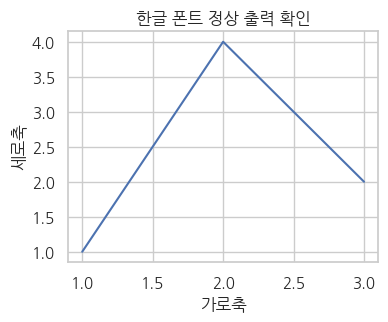

In [ ]:
# ==========================================
# 1. 한글 출력을 위한 기초 셀
# ==========================================

!apt-get update -qq
!apt-get install -y fonts-nanum

import matplotlib as mpl
print("matplotlibrc 경로:", mpl.matplotlib_fname())

import shutil
import matplotlib as mpl

root = mpl.matplotlib_fname().replace("matplotlibrc", "")
target_font = root + "fonts/ttf/DejaVuSans.ttf"
print("matplotlib 기본 폰트 파일:", target_font)

nanum_font = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
shutil.copyfile(nanum_font, target_font)
print("기본 폰트를 나눔고딕으로 교체 완료")

!rm -rf ~/.cache/matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(4,3))
plt.title("한글 폰트 정상 출력 확인")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.plot([1,2,3], [1,4,2])
plt.show()


In [ ]:
# ==========================================
# 2. 기본 라이브러리 임포트
# ==========================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import MarkerCluster

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 깨짐 방지


## 3. 대구 주차장 데이터 로드

`대구 주차장 정보.csv`는 Colab에서 **직접 업로드**하는 방식으로 불러옵니다.

- 실습 참여자가 각자 로컬에 있는 CSV를 업로드  
- 또는 구글 드라이브에 올려두고 경로를 바꾸어 사용할 수도 있습니다.


In [ ]:
# ==========================================
# 3. 대구 주차장 정보.csv 업로드 및 로드
# ==========================================
from google.colab import files

print("대구 주차장 정보.csv 파일을 선택해서 업로드 해주세요.")
uploaded = files.upload()

print("업로드된 파일 목록:", list(uploaded.keys()))
file_name = list(uploaded.keys())[0]
print("사용할 파일 이름:", file_name)

def read_csv_safe(path, encodings=["utf-8", "utf-8-sig", "cp949"]):
    """
    여러 인코딩을 시도하면서 CSV 파일을 안전하게 읽기 위한 함수.
    """
    last_error = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_error = e
            print(f"[경고] 인코딩 {enc} 로 읽기 실패: {e}")
            continue
    raise ValueError(f"CSV를 어떤 인코딩으로도 읽을 수 없습니다. 마지막 에러: {last_error}")

df = read_csv_safe(file_name)

print("데이터 로딩 완료!")
print("데이터 형태 (행, 열):", df.shape)


대구 주차장 정보.csv 파일을 선택해서 업로드 해주세요.


Saving 대구 보안등 정보.csv to 대구 보안등 정보.csv
업로드된 파일 목록: ['대구 보안등 정보.csv']
사용할 파일 이름: 대구 보안등 정보.csv
[경고] 인코딩 utf-8 로 읽기 실패: 'utf-8' codec can't decode byte 0xba in position 0: invalid start byte
[경고] 인코딩 utf-8-sig 로 읽기 실패: 'utf-8' codec can't decode byte 0xba in position 0: invalid start byte
데이터 로딩 완료!
데이터 형태 (행, 열): (71913, 8)


/tmp/ipython-input-577208307.py:20: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, encoding=enc)


In [ ]:
# ==========================================
# 4. 데이터 상위 10행 및 기본 요약 정보
# ==========================================

print("=== 대구 주차장 데이터 상위 10행 (head(10)) ===")
display(df.head(10))

print("\n=== 대구 주차장 데이터 기본 요약 ===")
total_rows = df.shape[0]
total_cols = df.shape[1]
missing_ratio = df.isnull().mean().mean() * 100

print(f"전체 행 수: {total_rows:,}")
print(f"전체 컬럼 수: {total_cols:,}")
print(f"평균 결측값 비율: {missing_ratio:.2f}%")

# 실제 데이터 확인 후, 교육용으로 예상 값을 주석으로 남겨도 좋습니다.


=== 대구 주차장 데이터 상위 10행 (head(10)) ===


,보안등위치명,설치개수,소재지도로명주소,소재지지번주소,위도,경도,설치연도,설치형태
0,대명1동1,1,대구광역시 남구 현충로 155,대구광역시 남구 대명동 1722-4,35.846703,128.579803,2016.0,한전주
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,대구광역시 남구 대명동 1723-11,35.846863,128.579406,2016.0,한전주
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,대구광역시 남구 대명동 1722-56,35.846341,128.579342,2017.0,건축물
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,대구광역시 남구 대명동 1722-41,35.846368,128.578922,2016.0,한전주
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,대구광역시 남구 대명동 1721-22,35.845995,128.578858,2016.0,한전주
5,대명1동6,1,대구광역시 남구 현충로29길 16-1,대구광역시 남구 대명동 1721-21,35.845993,128.579016,2016.0,한전주
6,대명1동7,1,대구광역시 남구 현충로29길 10-1,대구광역시 남구 대명동 1721-7,35.846028,128.579336,2016.0,한전주
7,대명1동8,1,대구광역시 남구 현충로 143,대구광역시 남구 대명동 1721-25,35.845990,128.579756,2016.0,한전주
8,대명1동9,1,대구광역시 남구 현충로29길 16-6,대구광역시 남구 대명동 1721-8,35.846216,128.579180,2016.0,전용주
9,대명1동10,1,대구광역시 남구 현충서길 28,대구광역시 남구 대명동 1718-5,35.845445,128.578404,2016.0,한전주



=== 대구 주차장 데이터 기본 요약 ===
전체 행 수: 71,913
전체 컬럼 수: 8
평균 결측값 비율: 30.06%


In [ ]:
# ==========================================
# 5. df.info()로 전체 스키마 확인
# ==========================================
print("=== 대구 주차장 데이터 info() ===")
df.info()


=== 대구 주차장 데이터 info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71913 entries, 0 to 71912
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   보안등위치명    71913 non-null  object 
 1   설치개수      71913 non-null  int64  
 2   소재지도로명주소  34646 non-null  object 
 3   소재지지번주소   71913 non-null  object 
 4   위도        43602 non-null  float64
 5   경도        43602 non-null  float64
 6   설치연도      29397 non-null  float64
 7   설치형태      35373 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 4.4+ MB


## 6. 수치형 / 범주형 컬럼 분리

주차장 데이터에서도 **수치형 / 범주형 컬럼을 자동으로 분리**합니다.

- 수치형: 주차면수, 요금, 면적 등 (있다면)  
- 범주형: 주차장 유형, 운영 방식, 행정동 등  

이 구분은 이후 Streamlit 대시보드에서도 동일하게 사용할 예정입니다.


In [ ]:
# ==========================================
# 6. 수치형 / 범주형 컬럼 분리
# ==========================================

numeric_cols = df.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("=== 수치형 컬럼 목록 ===")
print(numeric_cols)

print("\n=== 범주형 컬럼 목록 ===")
print(categorical_cols)


=== 수치형 컬럼 목록 ===
['설치개수', '위도', '경도', '설치연도']

=== 범주형 컬럼 목록 ===
['보안등위치명', '소재지도로명주소', '소재지지번주소', '설치형태']


## 7. 위도·경도 기반 지도 시각화 (Folium + MarkerCluster)

주차장 위치를 지도 위에 시각화하기 위해  
**Folium** 라이브러리와 **MarkerCluster** 플러그인을 사용합니다.

- Folium: Python에서 Leaflet.js 기반 지도를 그려주는 라이브러리  
- MarkerCluster: 많은 포인트를 클러스터 형태로 묶어 표시하는 기능  

### 절차
1. 주차장 데이터에서 **위도(latitude), 경도(longitude)** 컬럼 이름을 확인  
2. 해당 컬럼을 사용하여 Folium 지도 객체 생성  
3. MarkerCluster에 주차장 위치를 반복문으로 추가  
4. 클러스터된 지도를 출력  


In [ ]:
# ==========================================
# 7. 위도/경도 컬럼 자동 감지 및 Folium 지도 표시
# ==========================================

lat_candidates = ["위도", "lat", "LAT", "y", "Y좌표"]
lng_candidates = ["경도", "lon", "LONG", "lng", "x", "X좌표"]

lat_col = None
lng_col = None

for c in df.columns:
    if c in lat_candidates:
        lat_col = c
    if c in lng_candidates:
        lng_col = c

print("탐지된 위도 컬럼:", lat_col)
print("탐지된 경도 컬럼:", lng_col)

if (lat_col is None) or (lng_col is None):
    raise ValueError("위도/경도 컬럼명을 찾지 못했습니다. lat_candidates, lng_candidates 리스트를 확인해주세요.")

geo_df = df[[lat_col, lng_col]].dropna()
print("좌표 정보가 있는 행 수:", len(geo_df))

center_lat = geo_df[lat_col].mean()
center_lng = geo_df[lng_col].mean()

m = folium.Map(location=[center_lat, center_lng], zoom_start=11)

marker_cluster = MarkerCluster().add_to(m)

for _, row in geo_df.iterrows():
    folium.Marker(
        location=[row[lat_col], row[lng_col]],
        icon=folium.Icon(color="green", icon="car", prefix="fa")  # 아이콘/색상은 취향에 따라 변경 가능
    ).add_to(marker_cluster)

m


## 8. 수치형 변수에 대한 히스토그램 & 박스플롯

각 수치형 컬럼에 대해

- **히스토그램**: 분포를 전체적으로 확인  
- **박스플롯(Box Plot)**: 중앙값, IQR, 이상치 여부 등을 확인  

두 가지 그래프를 모두 그려 보며  
보안등 데이터의 수치 특성이 어떤 형태인지 파악합니다.


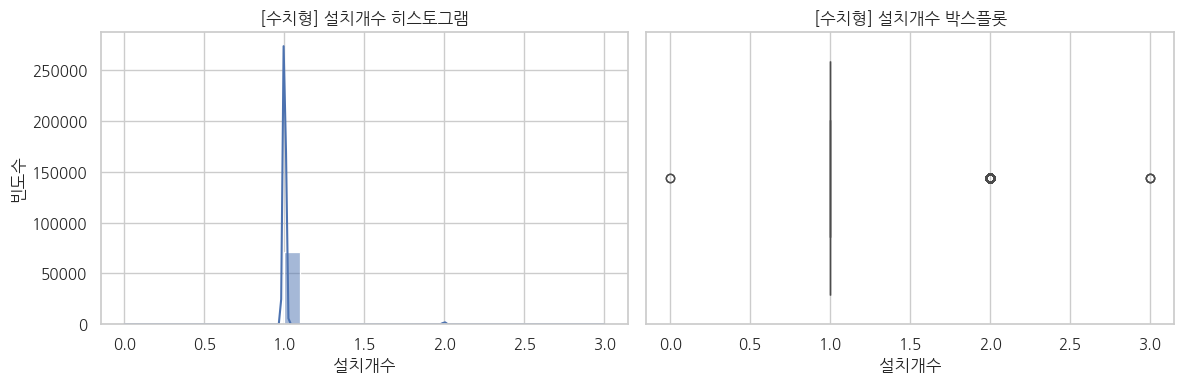

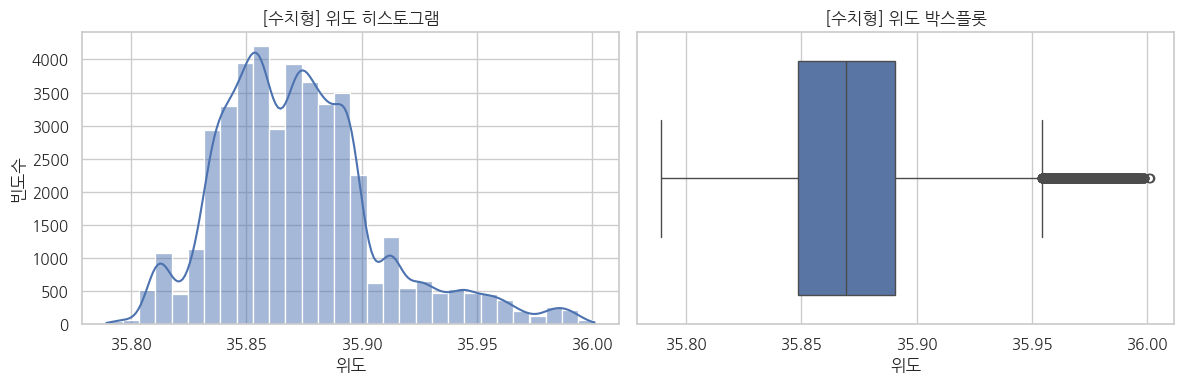

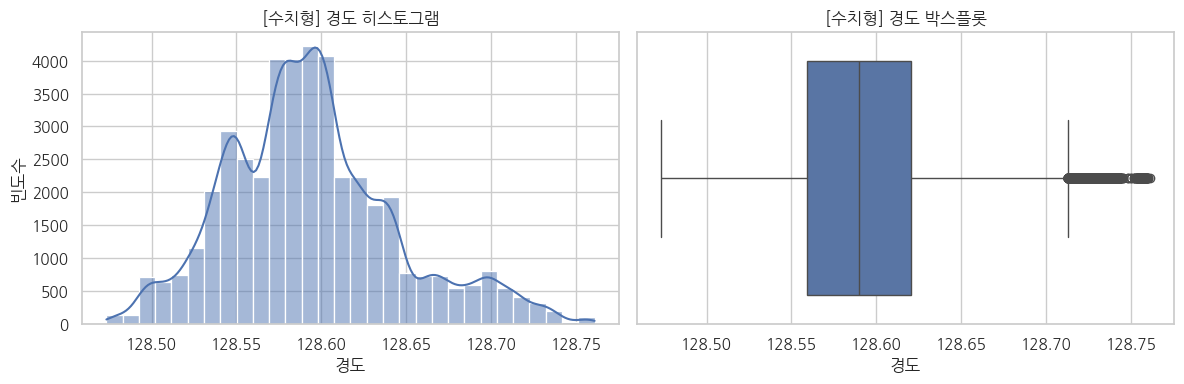

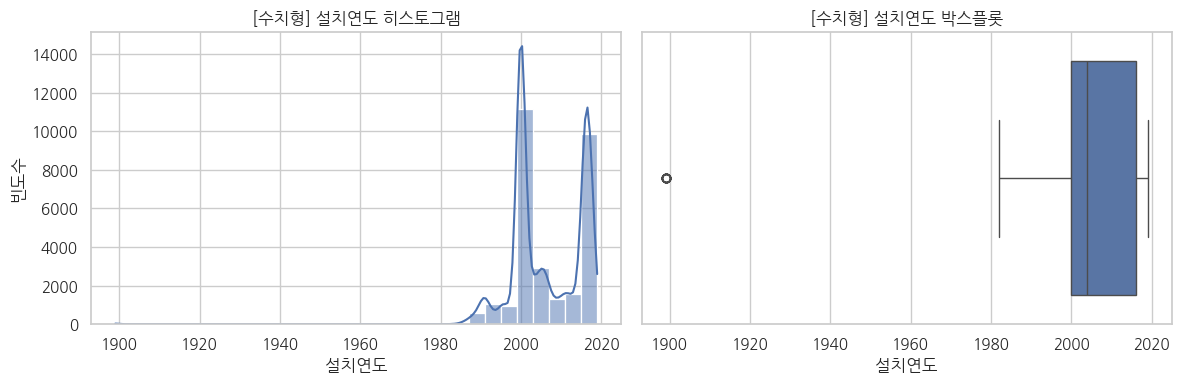

In [ ]:
# ==========================================
# 8. 모든 수치형 컬럼 히스토그램 + 박스플롯
# ==========================================

if len(numeric_cols) == 0:
    print("수치형 컬럼이 없어 시각화를 수행할 수 없습니다.")
else:
    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        sns.histplot(data=df, x=col, kde=True, bins=30, ax=axes[0])
        axes[0].set_title(f"[수치형] {col} 히스토그램")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("빈도수")

        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f"[수치형] {col} 박스플롯")
        axes[1].set_xlabel(col)

        plt.tight_layout()
        plt.show()


## 9. 범주형 변수에 대한 빈도수 bar chart

범주형 컬럼은 값이 얼마나 자주 등장하는지가 중요합니다.

- 예: 보안등 종류, 설치 위치 타입, 관리 기관 등  
- 각 컬럼별로 **상위 N개 카테고리**만 잘라서 bar chart로 표시합니다.


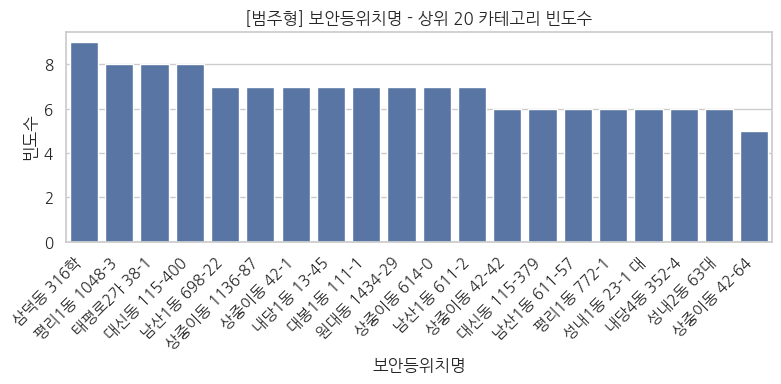

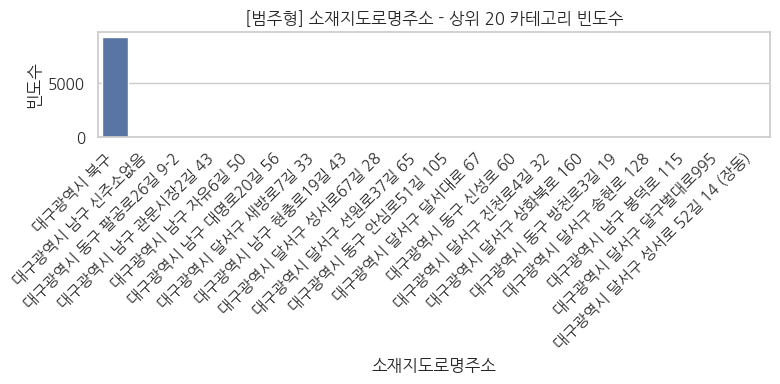

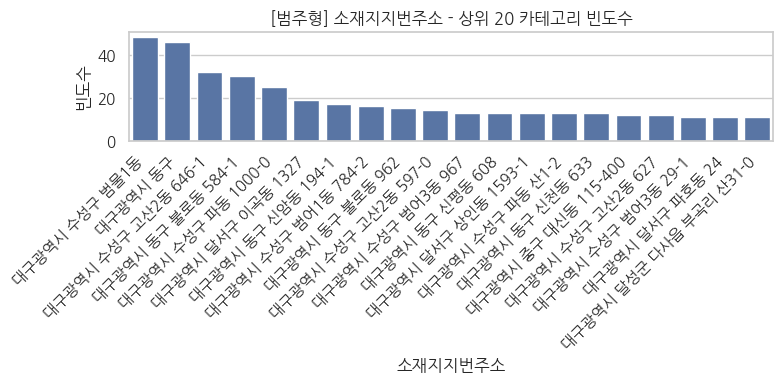

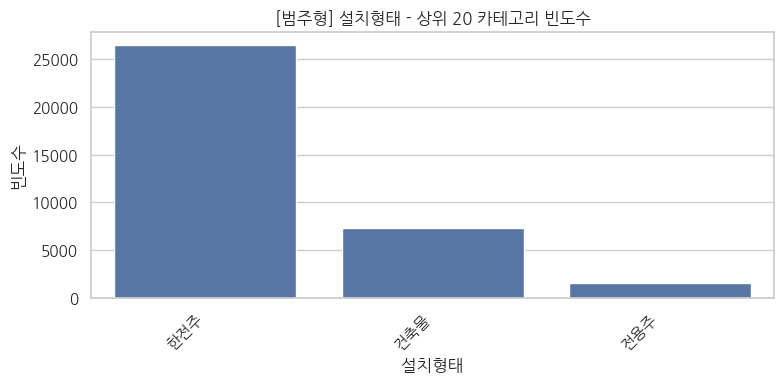

In [ ]:
# ==========================================
# 9. 모든 범주형 컬럼 bar chart
# ==========================================

TOP_N = 20  # 상위 몇 개 카테고리까지 시각화할지 설정

if len(categorical_cols) == 0:
    print("범주형 컬럼이 없어 bar chart를 그릴 수 없습니다.")
else:
    for col in categorical_cols:
        value_counts = df[col].value_counts().head(TOP_N)

        plt.figure(figsize=(8, 4))
        sns.barplot(x=value_counts.index.astype(str),
                    y=value_counts.values)
        plt.title(f"[범주형] {col} - 상위 {TOP_N} 카테고리 빈도수")
        plt.xlabel(col)
        plt.ylabel("빈도수")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


# 10. AI 대시보드 변경

8. AI와의 대화